In [11]:
import numpy as np
import cv2
import pywt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import os

In [2]:
def cwt_transform(matrix, wavelet='morl', scales=np.arange(1, 16, 1)):
    """
    对输入矩阵的每个通道进行 CWT，并返回 CWT 系数矩阵
    """
    h, w, c = matrix.shape  # (32,16,32)
    cwt_coeffs = np.zeros((h, w, len(scales), c))  # 存储 CWT 结果

    for i in range(c):  # 遍历 32 个通道
        for row in range(h):  # 对每一行信号进行 CWT
            coeffs, _ = pywt.cwt(matrix[row, :, i], scales, wavelet)
            cwt_coeffs[row, :, :, i] = np.abs(coeffs.T)  # 取绝对值以便可视化

    # 取不同尺度的均值（降低到 32×16×32）
    cwt_image = np.mean(cwt_coeffs, axis=2)  # (32,16,32)
    return cwt_image

def pca_to_rgb(matrix):
    """
    对 CWT 变换后的数据进行 PCA 降维，并归一化，到 RGB
    """
    h, w, c = matrix.shape  # (32,16,32)
    reshaped = matrix.reshape(-1, c)  # (512,32)

    # 使用 PCA 降维到 3 维
    pca = PCA(n_components=3)
    transformed = pca.fit_transform(reshaped)

    # 线性归一化到 0-255
    transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())  
    rgb_image = (transformed * 255).astype(np.uint8).reshape(h, w, 3)

    return rgb_image


In [3]:
data = np.load("../failure_prediction3d/data_processed/data_mce3d.npy")

In [9]:
label = np.load("../failure_prediction3d/data_processed/labels.npy")

In [5]:
def process_image(data, label, i):
    matrix = data
    matrix_transposed = np.transpose(matrix, (1, 2, 0))  # 交换轴顺序
    cwt_features = cwt_transform(matrix_transposed) # 提取cwt系数
    rgb_img = pca_to_rgb(cwt_features) # pca降维成rgb
    output_path = f"./normal/img_{i}.png" if label == 0 else f"./failure/img_{i}.png"
    cv2.imwrite(output_path, rgb_img)

In [8]:
# 确保输出目录存在
os.makedirs("./normal", exist_ok=True)
os.makedirs("./failure", exist_ok=True)
if __name__ == "__main__":
    num_workers = 14  # 适当控制进程数，避免过载

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        # 使用 zip() 逐个传递 data[i], label[i], i，避免整个 data 复制
        list(tqdm(executor.map(process_image, data, label, range(len(label))), total=len(label)))

    print("全部图片处理完成！")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30502/30502 [13:03<00:00, 38.94it/s]

全部图片处理完成！


In [ ]:
# 循环写法
for i in tqdm(range(len(label))) :
    matrix = data[i,:,:,:]
    matrix_transposed = np.transpose(matrix, (1, 2, 0))  # 交换轴顺序
    cwt_features = cwt_transform(matrix_transposed) # 提取cwt系数
    rgb_img = pca_to_rgb(cwt_features) # pca降维成rgb
    if label[i] == 0:
        cv2.imwrite(f"./normal/img_{i}.png", rgb_img)
    else :
        cv2.imwrite(f"./failure/img_{i}.png", rgb_img)
    

In [ ]:
# 显示图像
plt.imshow(rgb_img)
# plt.title("CWT-based RGB Image")
plt.axis("off")
plt.colorbar()
plt.show()

In [ ]:
cv2.imwrite("cwt_pca.png", rgb_img)

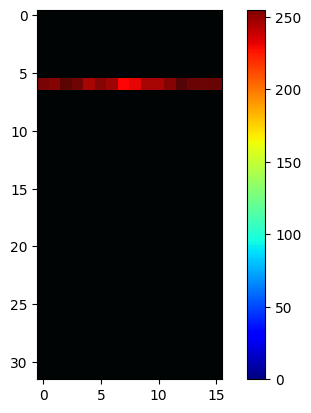

In [20]:
img = cv2.imread("./图像数据/1_failure/img_10002.png")
plt.imshow(img,"jet")
# plt.axis("off")
plt.colorbar()
plt.show()

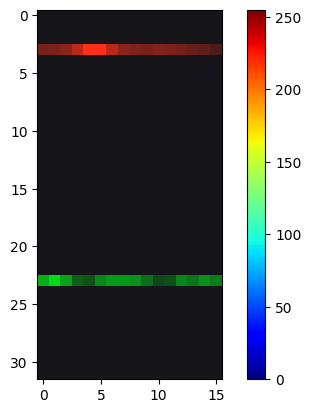

In [22]:
img = cv2.imread("./图像数据/1_failure/img_23495.png")
plt.imshow(img,"jet")
# plt.axis("off")
plt.colorbar()
plt.show()

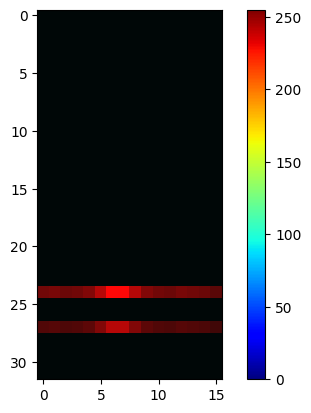

In [24]:
img = cv2.imread("./图像数据/1_failure/img_27867.png")
plt.imshow(img,"jet")
# plt.axis("off")
plt.colorbar()
plt.show()